## Задание
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
### 1. Учим conv сеть для классификации
### 2. Рассмотреть 2-а варианта сеточек:
    
### 2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
### 2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

In [35]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import nltk
from nltk.tokenize import word_tokenize
# nltk.download("punkt")
from nltk.probability import FreqDist

In [2]:
# pip install numpy==1.20.0

In [36]:
import tensorflow.keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

In [4]:
import matplotlib.pyplot as plt

In [5]:
max_words = 200
max_len = 40
num_classes = 5

# Training
epochs = 20
batch_size = 256
print_batch_n = 100

In [6]:
data = pd.read_csv("отзывы за лето.csv")

In [7]:
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [8]:
data.Rating.value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['Content'], data['Rating'])

In [10]:
X_train.head()

10361                                    Отлично работает.
7320                                                 Круто
19938    Приложение сырое и нужно много исправлений . И...
3337                              Приложение очень удобное
18909    Длилась час. Не закончилась. Приложение не зар...
Name: Content, dtype: object

In [11]:
y_train.head()

10361    5
7320     5
19938    3
3337     5
18909    5
Name: Rating, dtype: int64

### Предобработка

In [12]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [13]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()

In [14]:
tokens = word_tokenize(train_corpus)

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [15]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [16]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [17]:
tokens_filtered_top[:10]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'отличный',
 'телефон',
 'супер']

In [18]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [19]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [20]:
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
X_test = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [21]:
X_train.shape

(15494, 40)

In [22]:
X_train[1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 87], dtype=int32)

In [23]:
def change_category(y):
    new_y = []
    for num in y:
        new_y.append(num - 1)
    return new_y

In [24]:
# l = [1, 2, 3, 4]
# m = change_category(l)
# m

In [25]:
y_train = change_category(y_train)
y_test = change_category(y_test)

In [26]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [27]:
y_train[:2]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

### Строим сетку

In [37]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_le))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
# tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
# early_stopping=EarlyStopping(monitor='val_loss')


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)

2021-09-27 18:10:22.068873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


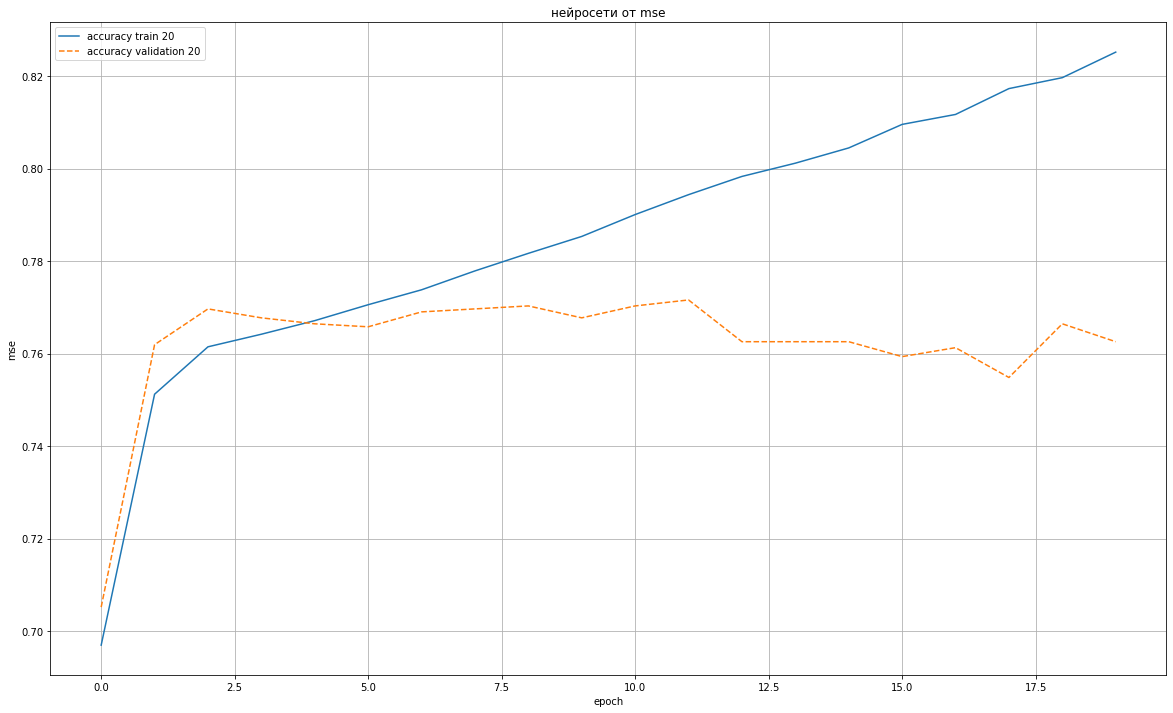

In [31]:
plt.figure(figsize=(20,12))
plt.plot(history.history['accuracy'], '-', label = f'accuracy train {epochs}')
plt.plot(history.history['val_accuracy'], '--', label = f'accuracy validation {epochs}')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от mse')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

In [32]:
score = model.evaluate(X_test, y_test, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

162/162 [==============================] - 0s 2ms/step - loss: 0.7106 - accuracy: 0.7632


Test score: 0.7106203436851501
Test accuracy: 0.7632139325141907


In [33]:
results = model.predict(X_test, batch_size=batch_size, verbose=1)

21/21 [==============================] - 0s 6ms/step


In [34]:
results

array([[1.4735125e-04, 1.7450050e-04, 1.1433588e-03, 3.0672806e-03,
        9.9546754e-01],
       [4.3187826e-04, 4.9655227e-04, 1.8419945e-03, 4.5163453e-02,
        9.5206612e-01],
       [4.4333702e-03, 7.2343801e-03, 2.7911935e-02, 2.1075168e-01,
        7.4966866e-01],
       ...,
       [1.5637091e-03, 2.1264525e-03, 7.6521747e-03, 1.2177548e-01,
        8.6688215e-01],
       [1.8302286e-03, 2.5093318e-03, 1.3396702e-02, 1.8635264e-02,
        9.6362841e-01],
       [2.3178452e-04, 6.6353509e-04, 5.3205104e-03, 3.2126606e-02,
        9.6165752e-01]], dtype=float32)

### Предобученный Embeding

In [ ]:
embedding_matrix = 

In [37]:
model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=128, weights=[embedding_matrix], input_length=max_le))
model2.add(Conv1D(128, 3))
model2.add(Activation("relu"))
model2.add(GlobalMaxPool1D())
model2.add(Dense(10))
model2.add(Activation("relu"))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [29]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
history2 = model2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)

2021-09-27 18:10:22.068873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


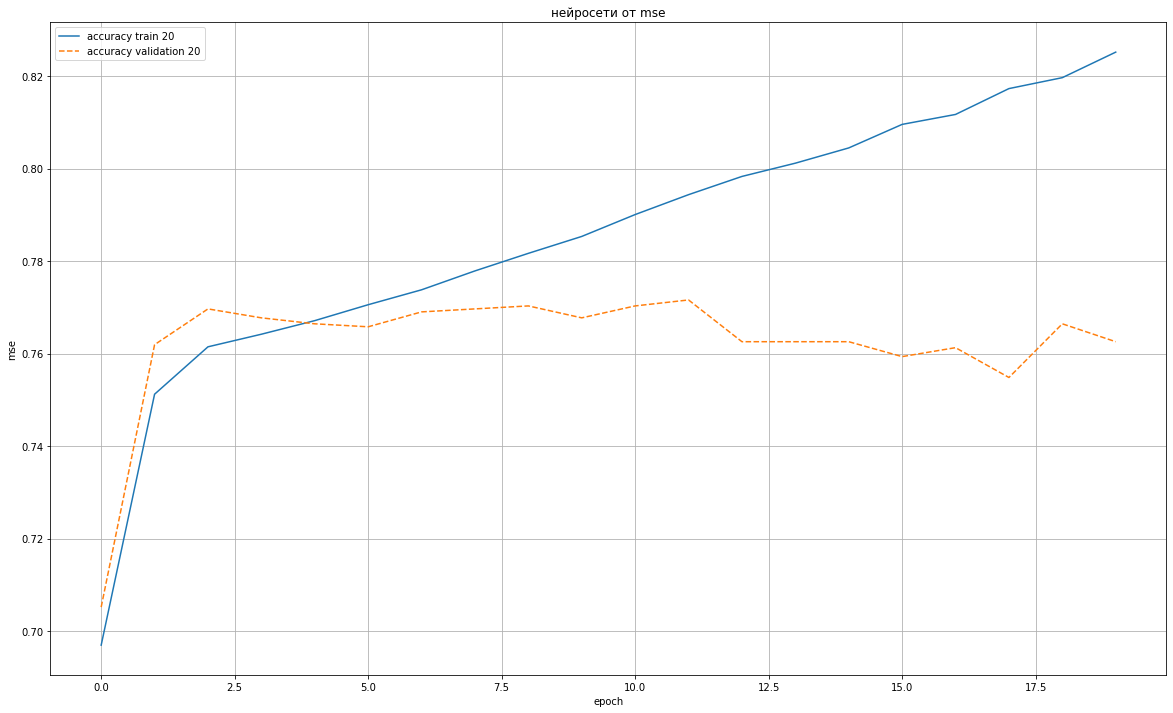

In [31]:
plt.figure(figsize=(20,12))
plt.plot(history2.history['accuracy'], '-', label = f'accuracy train {epochs}')
plt.plot(history2.history['val_accuracy'], '--', label = f'accuracy validation {epochs}')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от mse')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

In [32]:
score2 = model2.evaluate(X_test, y_test, verbose=1)
print('\n')
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

162/162 [==============================] - 0s 2ms/step - loss: 0.7106 - accuracy: 0.7632


Test score: 0.7106203436851501
Test accuracy: 0.7632139325141907


In [33]:
results2 = model2.predict(X_test, batch_size=batch_size, verbose=1)

21/21 [==============================] - 0s 6ms/step


In [34]:
results2

array([[1.4735125e-04, 1.7450050e-04, 1.1433588e-03, 3.0672806e-03,
        9.9546754e-01],
       [4.3187826e-04, 4.9655227e-04, 1.8419945e-03, 4.5163453e-02,
        9.5206612e-01],
       [4.4333702e-03, 7.2343801e-03, 2.7911935e-02, 2.1075168e-01,
        7.4966866e-01],
       ...,
       [1.5637091e-03, 2.1264525e-03, 7.6521747e-03, 1.2177548e-01,
        8.6688215e-01],
       [1.8302286e-03, 2.5093318e-03, 1.3396702e-02, 1.8635264e-02,
        9.6362841e-01],
       [2.3178452e-04, 6.6353509e-04, 5.3205104e-03, 3.2126606e-02,
        9.6165752e-01]], dtype=float32)